### Blood segmenting per available information

In [1]:
import numpy as np
import cv2
import pandas as pd
import requests

from matplotlib import pyplot as plt

In [2]:
#Function to download file from internet url
def get_image(url):
    local_filename = 'blood.jpg'
    
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    
    img = cv2.imread(local_filename)
    
    return img

In [3]:
def smear(xmin,ymin,xmax,ymax,img,type,color):
    if (xmin<2):
        xmin = 2
    if (ymin<2):
        ymin = 2

    tmp = np.ones([(ymax-ymin), 2, 3]) * 0
    img[ymin:ymax, (xmin-2):xmin, 0:3] = tmp
    tmp = np.ones([2,(xmax-xmin),3]) * 0
    img[(ymin-2):ymin, xmin:xmax, 0:3] = tmp
    tmp = np.ones([(ymax-ymin),2,3]) * 0
    img[ymin:ymax, (xmax-2):xmax, 0:3] = tmp
    tmp = np.ones([2,(xmax-xmin),3]) * 0
    img[(ymax-2):ymax, xmin:xmax, 0:3] = tmp

    cv2.putText(img, type, (xmin + 10, ymin + 15),
							cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * img.shape[0], color, 2)
    return 

In [4]:
# Crop the image given the coordinates of the cell
def blood_seg_new(xmin, ymin, xmax, ymax, img):
    y, x, c = img.shape
    img[0:ymin, :, :] = np.zeros([ymin, x, 3])
    img[ymax:, :, :] = np.zeros([y-ymax, x, 3])
    img[:, 0:xmin, :] = np.zeros([y, xmin, 3])
    img[:, xmax:, :] = np.zeros([y, x-xmax, 3])
    
    return 

In [5]:
#specify the csv path containing identifiers
csv_path = 'https://raw.githubusercontent.com/Shenggan/BCCD_Dataset/master/test.csv'
#specify root folder for blood images
root = 'https://raw.githubusercontent.com/Shenggan/BCCD_Dataset/master/BCCD/JPEGImages/'
#specify name of the input file

In [6]:
# Read annotations
df = pd.read_csv(csv_path)

In [7]:
# Read the image
blood = "BloodImage_00013.jpg"

rslt_df = df.loc[df['filename'] == blood]
img = get_image(root+blood)

Text(0.5, 1.0, 'Blood cells marked using annotations')

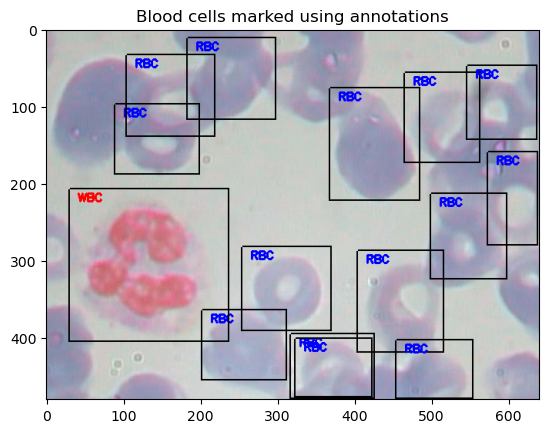

In [11]:
celltypes = ["RBC", "WBC", "Platelets"]
colors = [(0,0,255),(255,0,0),(0,0,0)]

ann_img = img.copy()

for i,name in enumerate(celltypes):
    rslt_df1 = rslt_df.loc[rslt_df['cell_type'] == name]

    for ind in rslt_df1.index:
        xmin = int(rslt_df1["xmin"][ind])
        xmax = int(rslt_df1["xmax"][ind])
        ymin = int(rslt_df1["ymin"][ind])
        ymax = int(rslt_df1["ymax"][ind])
        smear(xmin,ymin,xmax,ymax,ann_img,type=name,color=colors[i])

plt.imshow(ann_img)
plt.title('Blood cells marked using annotations')

Text(0.5, 1.0, 'HSV image ')

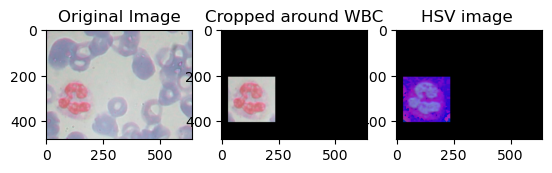

In [10]:
# Crop the image around a single WBC
type = 'WBC'
rslt_df1 = rslt_df.loc[rslt_df['cell_type'] == type]

crp_img = img.copy()

ind = rslt_df1.index[0]
xmin = int(rslt_df1["xmin"][ind])
xmax = int(rslt_df1["xmax"][ind])
ymin = int(rslt_df1["ymin"][ind])
ymax = int(rslt_df1["ymax"][ind])

blood_seg_new(xmin, ymin, xmax, ymax, crp_img)

hsv_img = cv2.cvtColor(crp_img, cv2.COLOR_BGR2HSV)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[1].imshow(crp_img)
axes[1].set_title('Cropped around ' + type)
axes[2].imshow(hsv_img)
axes[2].set_title('HSV image ')

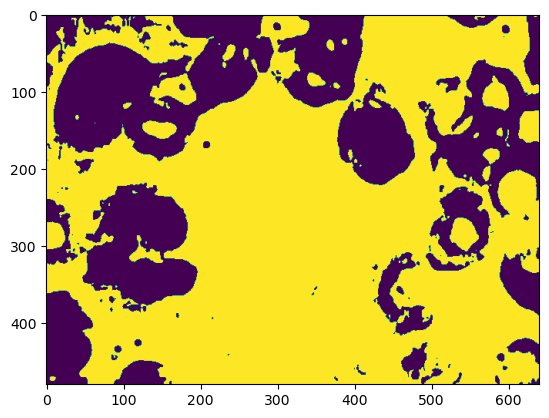

In [28]:
# Otsu's binary thresholding
# Adapted from https://learnopencv.com/otsu-thresholding-with-opencv/
blur = cv2.GaussianBlur(img, (5, 5), 0)
h, s, v = cv2.split(blur)

# Applying Otsu's method setting the flag value into cv.THRESH_OTSU.
# Use a bimodal image as an input.
# Optimal threshold value is determined automatically.
otsu_th, image_result = cv2.threshold(
    v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
)

plt.imshow(image_result)